Here, we examine parametric sensitivity of the structure model on a small simulated dataset

In [1]:
import jax

import jax.numpy as np
import jax.scipy as sp

from numpy.polynomial.hermite import hermgauss
import scipy as osp

from vb_lib import structure_model_lib, data_utils, cavi_lib, plotting_utils
import vb_lib.structure_optimization_lib as s_optim_lib

from vb_lib.preconditioner_lib import get_mfvb_cov_matmul
from bnpmodeling_runjingdev.sensitivity_lib import HyperparameterSensitivityLinearApproximation

import paragami

from copy import deepcopy

import time

import matplotlib.pyplot as plt
%matplotlib inline  

from bnpmodeling_runjingdev import cluster_quantities_lib, modeling_lib


/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
import numpy as onp
onp.random.seed(53453)

# Draw data

In [3]:
data_file = '../simulated_data/simulated_structure_data_nobs20_nloci50_npop4.npz'
data = np.load(data_file)

# the observations
g_obs = np.array(data['g_obs'], dtype = int)

n_obs = g_obs.shape[0]
n_loci = g_obs.shape[1]

# the ground truth 
true_ind_admix_propn = data['true_ind_admix_propn']

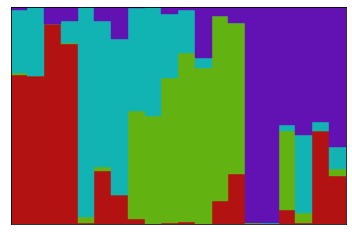

In [4]:
fig, axarr = plt.subplots(1, 1)
plotting_utils.plot_admixture(true_ind_admix_propn, axarr);

In [5]:
g_obs.shape

(20, 50, 3)

Text(0.5, 0, 'individual')

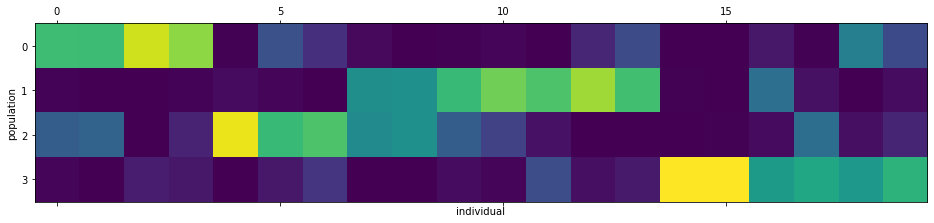

In [6]:
plt.matshow(true_ind_admix_propn.T)
plt.ylabel('population')
plt.xlabel('individual')

# Get prior

In [7]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

print(prior_params_paragami)

prior_params_free = prior_params_paragami.flatten(prior_params_dict, free = True)

OrderedDict:
	[dp_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_beta] = NumericArrayPattern (1,) (lb=0.0, ub=inf)


# Get VB params 

In [8]:
k_approx = 15

In [9]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

In [10]:
use_logitnormal_sticks = True

vb_params_dict, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs, n_loci, k_approx,
                                    use_logitnormal_sticks = use_logitnormal_sticks)
    
print(vb_params_paragami)

OrderedDict:
	[pop_freq_beta_params] = NumericArrayPattern (50, 15, 2) (lb=0.0, ub=inf)
	[ind_admix_params] = OrderedDict:
	[stick_means] = NumericArrayPattern (20, 14) (lb=-inf, ub=inf)
	[stick_infos] = NumericArrayPattern (20, 14) (lb=0.0001, ub=inf)


## Initialize 

In [11]:
vb_params_dict = \
        s_optim_lib.set_init_vb_params(g_obs, k_approx, vb_params_dict,
                                       prior_params_dict, 
                                       gh_loc, gh_weights,
                                       seed = 34221)

running NMF ...
running a few cavi steps for pop beta ...
done. Elapsed: 6.32253


Text(0.5, 0, 'individual')

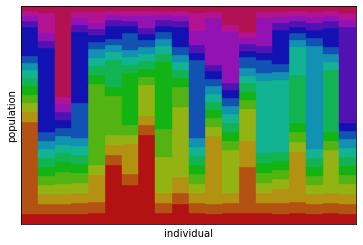

In [12]:
e_ind_admix = plotting_utils.get_vb_expectations(vb_params_dict, gh_loc, gh_weights)[0]

fig, axarr = plt.subplots(1, 1)
plotting_utils.plot_admixture(e_ind_admix, axarr);

plt.ylabel('population')
plt.xlabel('individual')

# Optimize

In [13]:
from vb_lib.structure_preconditioned_optimization_lib import optimize_structure

In [14]:
vb_opt_dict, vb_opt, out, precond_objective = \
    optimize_structure(g_obs, 
                        vb_params_dict, 
                        vb_params_paragami,
                        prior_params_dict,
                        gh_loc, gh_weights)


compiling objectives ... 
done. Elasped: 12.9325
compiling preconditioned objective ... 
done. Elasped: 18.9806
Run a few iterations without preconditioning ... 
iteration [20]; kl:1872.535429; elapsed: 0.5843secs
iteration [40]; kl:1834.515061; elapsed: 0.9546secs
iteration [60]; kl:1830.238731; elapsed: 0.8743secs
iteration [80]; kl:1830.096832; elapsed: 0.9049secs
iteration [84]; kl:1830.096807; elapsed: 0.2431secs
lbfgs converged successfully
done. Elapsed 3.6734


# Check out the fit

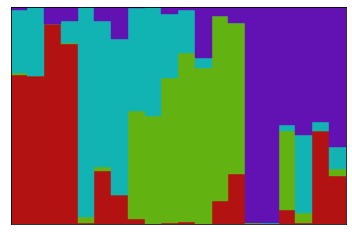

In [15]:
# truth 

fig, axarr = plt.subplots(1, 1)
plotting_utils.plot_admixture(true_ind_admix_propn, axarr);

Text(0.5, 0, 'individual')

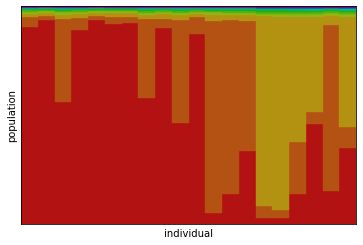

In [16]:
# estimated 

e_ind_admix = plotting_utils.get_vb_expectations(vb_opt_dict, gh_loc, gh_weights)[0]

fig, axarr = plt.subplots(1, 1)
plotting_utils.plot_admixture(e_ind_admix, axarr);

plt.ylabel('population')
plt.xlabel('individual')

# Define sensitivity object

In [17]:
# initial prior alpha
use_free_alpha = True
prior_alpha0 = prior_params_paragami['dp_prior_alpha'].flatten(prior_params_dict['dp_prior_alpha'], 
                                                              free = use_free_alpha)

In [18]:
# set up objective as function of vb params and prior param 

def objective_fun(vb_params_dict, alpha): 
    
    _prior_params_dict = deepcopy(prior_params_dict)
    _prior_params_dict['dp_prior_alpha'] = alpha
    
    return structure_model_lib.get_kl(g_obs, vb_params_dict, _prior_params_dict,
                    gh_loc = gh_loc, gh_weights = gh_weights)


objective_fun_free = paragami.FlattenFunctionInput(
                                original_fun=objective_fun, 
                                patterns = [vb_params_paragami, prior_params_paragami['dp_prior_alpha']],
                                free = [True, use_free_alpha],
                                argnums = [0, 1])


In [19]:
objective_fun_free(vb_opt, prior_alpha0)

DeviceArray(1830.09680684, dtype=float64)

### Set up hessian solver

In [20]:
# define preconditioner
cg_precond = lambda v : get_mfvb_cov_matmul(v, vb_opt_dict,
                                            vb_params_paragami,
                                            return_info = True)

preconditioner time: 1.36sec


In [21]:
vb_sens = HyperparameterSensitivityLinearApproximation(objective_fun_free,
                                                        vb_opt,
                                                        prior_alpha0, 
                                                        cg_precond=cg_precond)


Compiling ...
Compile time: 96.8635sec



# Perturb alpha. Check results

In [22]:
# set new alpha 
new_alpha = np.array([5.])

prior_params_pert_dict = deepcopy(prior_params_dict)
prior_params_pert_dict['dp_prior_alpha'] = new_alpha


In [23]:
print('initial alpha, ', prior_params_dict['dp_prior_alpha'])
print('perturbed alpha, ', prior_params_pert_dict['dp_prior_alpha'])


initial alpha,  [3.]
perturbed alpha,  [5.]


In [24]:
# linear response prediction 
lr_vb_free_params = \
    vb_sens.predict_opt_par_from_hyper_par(
        prior_params_paragami['dp_prior_alpha'].flatten(prior_params_pert_dict['dp_prior_alpha'], 
                                                        free = use_free_alpha))

print('l_inf diff: ', np.max(np.abs(lr_vb_free_params - vb_opt)))


l_inf diff:  0.9439231844131095


In [25]:
(lr_vb_free_params**2).mean()

DeviceArray(1.14784954, dtype=float64)

### reoptimize

In [26]:
new_init_dict = deepcopy(vb_opt_dict)
new_init_free = vb_params_paragami.flatten(new_init_dict, free = True)

In [27]:
vb_pert_dict, vb_opt_pert, _, _ = \
    optimize_structure(g_obs, 
                        new_init_dict, 
                        vb_params_paragami,
                        prior_params_pert_dict,
                        gh_loc, gh_weights)


compiling objectives ... 
done. Elasped: 11.9577
compiling preconditioned objective ... 
done. Elasped: 19.9263
Run a few iterations without preconditioning ... 
iteration [20]; kl:2062.024901; elapsed: 0.477secs
iteration [37]; kl:2062.020843; elapsed: 0.7556secs
lbfgs converged successfully
done. Elapsed 1.2483


### compare

In [28]:
def print_diff_plot(lr_vb_free_params, vb_opt_pert, vb_opt): 
    plt.plot(lr_vb_free_params - vb_opt, 
             vb_opt_pert - vb_opt, 
             '+', color = 'red')

    plt.plot(lr_vb_free_params - vb_opt, 
            lr_vb_free_params - vb_opt, 
             '-', color = 'blue')

    plt.xlabel('lr')
    plt.ylabel('re-optimized')


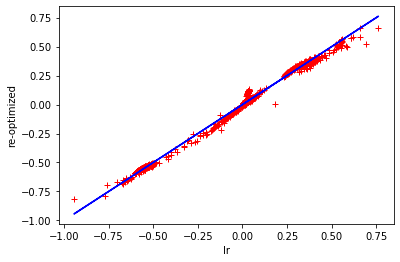

In [29]:
# compare free parameters
print_diff_plot(lr_vb_free_params, vb_opt_pert, vb_opt)

In [30]:
key = jax.random.PRNGKey(1)

def get_e_num_pred_clusters(vb_params_dict): 
    
    stick_means = vb_params_dict['ind_admix_params']['stick_means']
    stick_infos = vb_params_dict['ind_admix_params']['stick_infos']
    
    return structure_model_lib.get_e_num_pred_clusters(stick_means, stick_infos, gh_loc, gh_weights, 
                                                            key, n_samples = 10000)

In [31]:
print('init number of cluster: ', get_e_num_pred_clusters(vb_opt_dict))
print('pert number of cluster: ', get_e_num_pred_clusters(vb_pert_dict))
print('lr number of cluster: ', get_e_num_pred_clusters(vb_params_paragami.fold(lr_vb_free_params, 
                                                                                free = True)))

init number of cluster:  3.7416292673731193
pert number of cluster:  4.462091623857604
lr number of cluster:  4.441936192878204


# Fit for a range of alpha

In [32]:
alpha_list = np.arange(1, 8)

In [33]:
def refit_with_alpha(alpha, new_init_dict):
    # sets new alpha, returns new vb optimum
    
    # set new prior
    new_alpha = np.array([alpha])

    prior_params_pert_dict = deepcopy(prior_params_dict)
    prior_params_pert_dict['dp_prior_alpha'] = new_alpha
    
    # set new objective 
    _, vb_opt_pert, _, _ = \
        optimize_structure(g_obs, 
                            new_init_dict, 
                            vb_params_paragami,
                            prior_params_pert_dict,
                            gh_loc, gh_weights)

        
    return vb_opt_pert


In [34]:
print('alphas: ', alpha_list)

alphas:  [1 2 3 4 5 6 7]


In [35]:
vb_pert_list = []
for alpha in alpha_list: 
    print('\n re-optimzing with alpha = ', alpha)
    
    vb_pert_list.append(refit_with_alpha(alpha, new_init_dict))



 re-optimzing with alpha =  1
compiling objectives ... 
done. Elasped: 11.6849
compiling preconditioned objective ... 
done. Elasped: 19.4557
Run a few iterations without preconditioning ... 
iteration [20]; kl:1417.091422; elapsed: 0.5039secs
iteration [37]; kl:1417.058983; elapsed: 0.7767secs
lbfgs converged successfully
done. Elapsed 1.2959

 re-optimzing with alpha =  2
compiling objectives ... 
done. Elasped: 11.5289
compiling preconditioned objective ... 
done. Elasped: 18.9484
Run a few iterations without preconditioning ... 
iteration [20]; kl:1664.905909; elapsed: 0.5043secs
iteration [34]; kl:1664.902439; elapsed: 0.6742secs
lbfgs converged successfully
done. Elapsed 1.1941

 re-optimzing with alpha =  3
compiling objectives ... 
done. Elasped: 12.3101
compiling preconditioned objective ... 
done. Elasped: 19.3447
Run a few iterations without preconditioning ... 
iteration [1]; kl:1830.096804; elapsed: 0.0708secs
iteration [2]; kl:1830.096802; elapsed: 0.1263secs
lbfgs conve

# Check free parameters

In [36]:
lr_list = []

for alpha in alpha_list: 
    
    # set alpha 
    new_alpha = np.array([alpha])
    prior_params_pert_dict = deepcopy(prior_params_dict)
    prior_params_pert_dict['dp_prior_alpha'] = new_alpha
    
    # get linear response
    lr_list.append(vb_sens.predict_opt_par_from_hyper_par(
        prior_params_paragami['dp_prior_alpha'].flatten(prior_params_pert_dict['dp_prior_alpha'], 
                                                        free = use_free_alpha)))


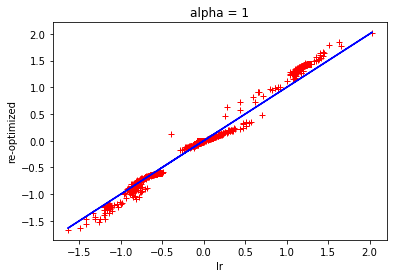

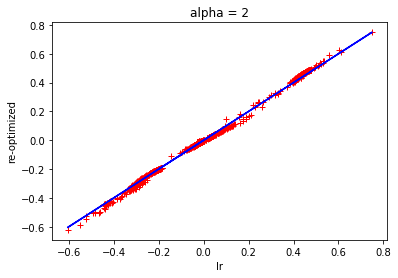

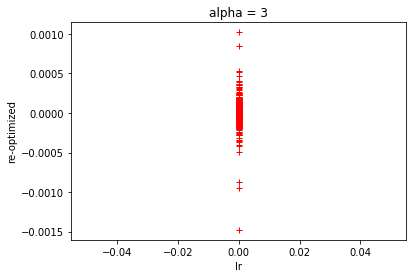

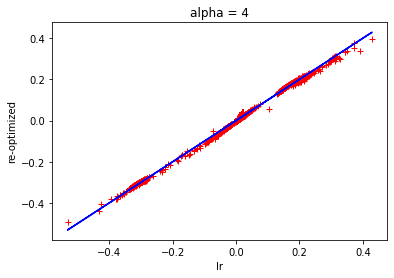

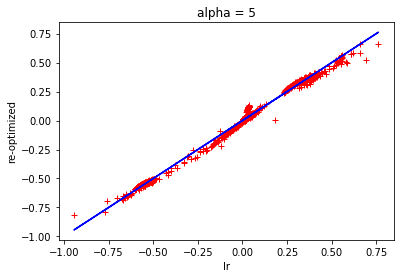

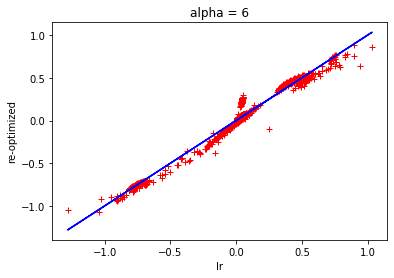

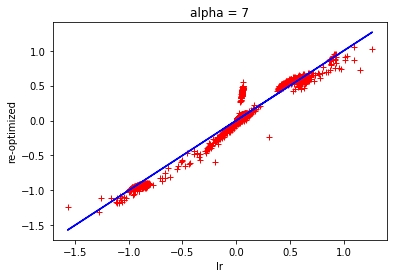

In [37]:
for i in range(len(alpha_list)): 
    plt.figure()
    print_diff_plot(lr_list[i], vb_pert_list[i], vb_opt)
    
    plt.title('alpha = {}'.format(alpha_list[i]))


# Number of clusters

In [38]:
import numpy as onp

In [39]:
lr_e_num_clusters_vec = onp.zeros(len(alpha_list))
refit_e_num_clusters_vec = onp.zeros(len(alpha_list))

for i in range(len(alpha_list)): 
    
    # get dictionaries
    pert_dict = vb_params_paragami.fold(vb_pert_list[i], free = True)
    lr_dict = vb_params_paragami.fold(lr_list[i], free = True)
    
    # get posterior expectations
    pert_e_ind_admix, pert_e_pop_freq = plotting_utils.get_vb_expectations(pert_dict, gh_loc, gh_weights)
    lr_e_ind_admix, lr_e_pop_freq = plotting_utils.get_vb_expectations(lr_dict, gh_loc, gh_weights)
    
    # get number of clusters
    refit_e_num_clusters_vec[i] = cluster_quantities_lib.get_e_num_clusters_from_ez(pert_e_ind_admix)
    lr_e_num_clusters_vec[i] = cluster_quantities_lib.get_e_num_clusters_from_ez(lr_e_ind_admix)


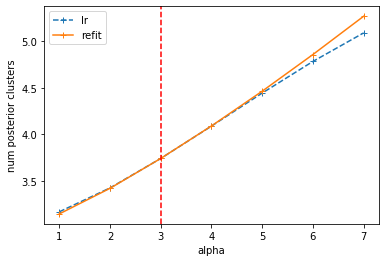

In [40]:
plt.plot(alpha_list, lr_e_num_clusters_vec, '+--')
plt.plot(alpha_list, refit_e_num_clusters_vec, '+-')

plt.xlabel('alpha')
plt.ylabel('num posterior clusters')
plt.legend(('lr', 'refit'))

plt.axvline(prior_params_dict['dp_prior_alpha'], color = 'red', linestyle = 'dashed')